In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
from batterylearn.models import Flywheel, OCV, EcmCell
from batterylearn.utilities import ivp
from batterylearn.simulations import Data, Current, Learner,Simulator
import os
import matplotlib.pyplot as plt

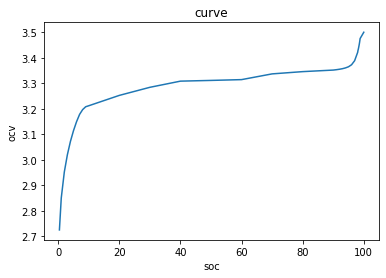

In [2]:

ocv = [
    2.725578,
    2.850545,
    2.952456,
    3.020007,
    3.072155,
    3.114243,
    3.149442,
    3.178211,
    3.196915,
    3.208162,
    3.21203,
    3.252616,
    3.284272,
    3.308415,
    3.311269,
    3.314391,
    3.336869,
    3.345692,
    3.351787,
    3.353211,
    3.354968,
    3.357175,
    3.360247,
    3.364758,
    3.372647,
    3.388452,
    3.421374,
    3.428617,
    3.433137,
    3.438826,
    3.444884,
    3.4514,
    3.458486,
    3.466429,
    3.475249,
    3.5,
]
soc = [
    0.397351,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    20,
    30,
    40,
    50,
    60,
    70,
    80,
    90,
    91,
    92,
    93,
    94,
    95,
    96,
    97,
    98,
    98.1,
    98.2,
    98.3,
    98.4,
    98.5,
    98.6,
    98.7,
    98.8,
    100.0,
]

c1 = OCV(name="curve1", ocv=ocv, soc=soc)

c1.display()

the training dataset has a gap , during which the cell is relaxing,

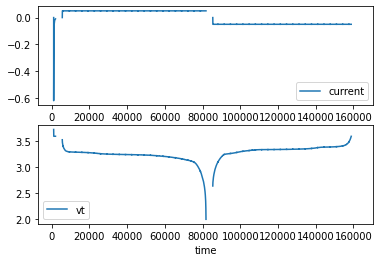

In [3]:

TESTDATA_FILEPATH = os.path.join(os.path.dirname(os.getcwd()),
'tests/cycling/main-data-as-seriestocolumns-2022-08-02 23_32_07.xlsx')

# data come from https://web.calce.umd.edu/batteries/data.htm

schema = {
    "Time": "time",
    "Cell_LFP_CALCE_A1_007.max_current": "current",
    "Cell_LFP_CALCE_A1_007.max_v_tr": "vt",
    "rsv_i_dir": False,
}
d1 = Data(name="d1", df=None)
d1.fetch_file(TESTDATA_FILEPATH, schema=schema)
d1.to_abs_time()
d1.disp()

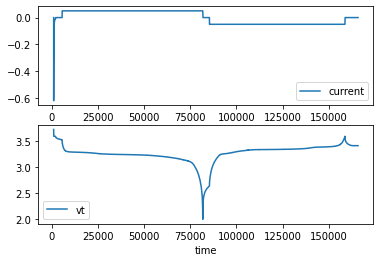

In [4]:
d1.df.interpolate(method='linear',inplace=True)
d1.df.dropna(inplace=True)
d1.disp()

In [5]:
d1.df.reset_index(inplace=True)

In [21]:
param_sim = {
    "R0": 0.1,
    "R1": 0.1,
    "tau1": 2,
    "R2": 0.1,
    "tau2": 1,
    "CAP": 1.1,
    "ce": 0.99,
    "v_limits": [1.5, 4.5],
    "SOC_RANGE": [0.0, 100.0],
}
m_sim = EcmCell(name="cell_model_sim", parameters=param_sim, curve=c1)
l2 = Learner(name="l2")
l2.attach(d1).attach(m_sim)
x0_sim = np.array([-0.05, -0.05, 100])

config = {
    "solver_type": "adaptive",
    "solution_name": "sol1",
    "max_step":np.inf,
    'maxiter':200,
    'maxfev':2000,
    'method':'Powell'}

method = "diff"
bounds=(
    (1e-4, 1),
    (1e-4, 1),
    (1, 10),
    (1e-4, 1),
    (.1, 10),
    (0.9, 1.2),
)

res = l2.fit_parameters(("cell_model_sim", "d1"), config, x0_sim, method,bounds)

/workspaces/batterylearn/.venv/lib/python3.10/site-packages/scipy/optimize/_differentialevolution.py:377: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 0.00250563
differential_evolution step 2: f(x)= 0.00250563
differential_evolution step 3: f(x)= 0.00241675
differential_evolution step 4: f(x)= 0.00235534
differential_evolution step 5: f(x)= 0.00194964
differential_evolution step 6: f(x)= 0.0019476
differential_evolution step 7: f(x)= 0.00187286
differential_evolution step 8: f(x)= 0.00187286
differential_evolution step 9: f(x)= 0.00184181
differential_evolution step 10: f(x)= 0.00184181
differential_evolution step 11: f(x)= 0.00182171
differential_evolution step 12: f(x)= 0.00182171
differential_evolution step 13: f(x)= 0.00174899
differential_evolution step 14: f(x)= 0.0017459
differential_evolution step 15: f(x)= 0.00170742
differential_evolution step 16: f(x)= 0.00170742
differential_evolution step 17: f(x)= 0.00162209
differential_evolution step 18: f(x)= 0.00162209
differential_evolution step 19: f(x)= 0.00162209
differential_evolution step 20: f(x)= 0.00162209
differential_evolution step 21:

the extracted R0 is 0.13004402439145235, R1 is 0.8249520380341396, tau1 is 9.997008603941275, R2 is 0.8658960072040534, tau2 is 0.5125140187216681, CAP is 1.050523471614374
tau1 is 9.997008603941275 min
tau2 is 0.5125140187216681 hours


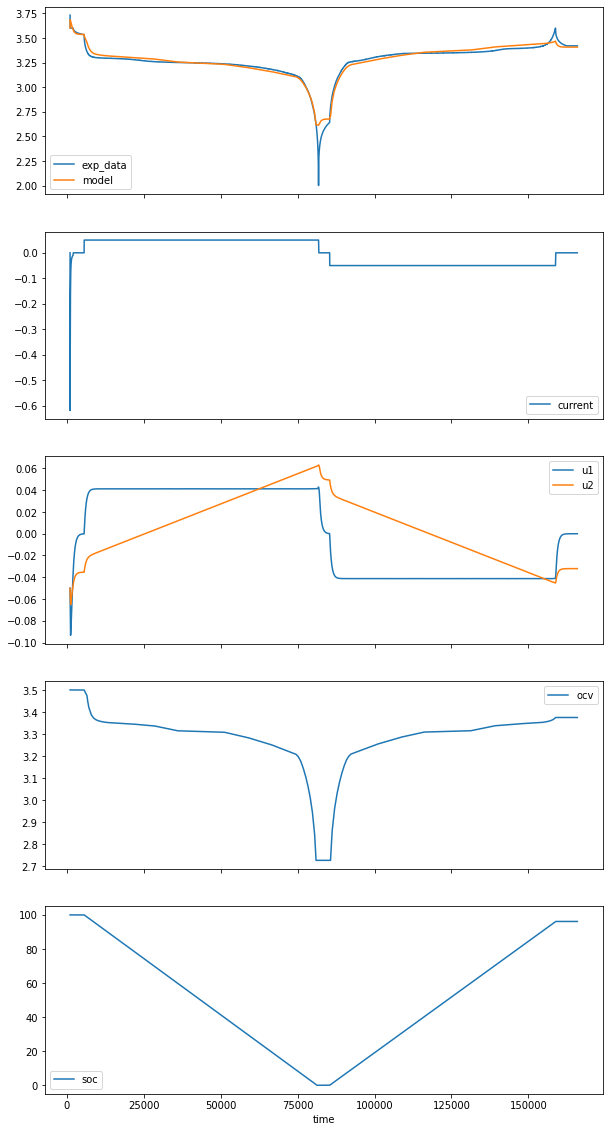

Bad pipe message: %s [b'\xfc\x13\xaa\x92\xe2]\x07\x03?T\xc1\xd2\x1e\xeb\x17\\\x88\xa8 \xca\xf6\x85\x85\xcac\x88\x13L\xa9\xff\xbb\xbd\xe8PS\xaaC\xec*\xb1\xccq\xe2}c[\xad\xf6/\xf8\x13\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01']
Bad pipe message: %s [b'SUg\xf0=\xf8j\x8fN\x92\xf8\xfb\x19\xca\x1b\xf1a\xd8\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9', b"\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00.\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x0

In [20]:
a = list(map(lambda x,y:(y[1] - y[0])*x+y[0], res.x, bounds))

print('the extracted R0 is {}, R1 is {}, tau1 is {}, R2 is {}, tau2 is {}, CAP is {}'.format(*a))
print('tau1 is {} min'.format(a[2]))
print('tau2 is {} hours'.format(a[4]))

param_exr = {
    "R0": a[0],
    "R1": a[1],
    "tau1": a[2],
    "R2": a[3],
    "tau2": a[4],
    "CAP": a[5],
    "ce": 0.99,
    "v_limits": [1.5, 4.5],
    "SOC_RANGE": [0.0, 100.0],
}

m_exr = EcmCell(name="cell_model_exr", parameters=param_exr, curve=c1)

s3 = Simulator(name="s3")
s3.attach(d1).attach(m_exr)
d3 = s3.run(("cell_model_exr", "d1"), x0_sim)

fig,  ax = plt.subplots(5,1,sharex=True,figsize=(10,20))

# ax[0].set_ylim(bottom=2.5,top=3.8)
# ax[0].set_ylim(bottom=-.75,top=.1)
d1.df.plot(ax=ax[0],x='time',y='vt',label='exp_data')
d3.df.plot(ax=ax[0],x='time',y='vt',label='model' )
d1.df.plot(ax=ax[1],x='time',y='current',label='current')
d3.df.plot(ax=ax[2],x='time',y='u1',label='u1')
d3.df.plot(ax=ax[2],x='time',y='u2',label='u2')
d3.df.plot(ax=ax[3],x='time',y='ocv',label='ocv')
d3.df.plot(ax=ax[4],x='time',y='soc',label='soc')
plt.show()
